# Supervised Learning Final Project: Handwritten Digit Classification

for my final project I choosed **Handwritten Digit Classification**. So in this project, I will go thorugh supervised learning process, starting with raw data and ending with a model that can correctly identify handwritten digits. Digit classification might sound simple, but it’s actually **used in real world tasks like sorting mail or reading checks**. So, I wanted to see how well different machine learning models could handle this problem.

This dataset is perfect for learning because it’s small, clean, and balanced. Each digit (0–9) has about 180 samples, which means I don’t have to worry about imbalanced classes skewing the results. My goal was to walk through every step: cleaning the data, exploring patterns, training models, tuning them, and finally understanding where they succeed or fail.




## 1. Problem Statement and Motivation

So in this project, I am working on a supervised multi-class classification problem where I predict handwritten digits from 0 to 9 based on small grayscale images. Since these images are represented by pixel intensity features, my goal is to sort of understand how well they help in making accurate predictions. I chose this dataset because the reason is sort of simple and clear. Since digit classification is useful in practical applications like sorting mail, banking, and making digital records, I mean, it has a lot of practical importance. Based on that, using this dataset makes sense because it is balanced and easy to work with. So, I don’t have to worry about handling problems that come from imbalanced classes. My focus is more on selecting the right model, tuning hyperparameters, and deeply understanding the results. Because of this, I can sort of **concentrate on the actual learning process** instead of extra difficulties.


In [1]:
# === Cell 1: Import & load dataset ===
from sklearn.datasets import load_digits
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 2. Data Source and Description

So, I got this dataset from the famous UCI Machine Learning Repository, and it is specifically the Optical Recognition of Handwritten Digits dataset. Since it is available to the public, you can access it through [this direct link](https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits). Additionally, I used scikit-learn’s built-in loader (`load_digits()`), documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html), to simplify data import.

Based on that, the dataset has exactly 1,797 samples, and each one is represented by 64 pixel intensity values. My data is sort of arranged in an 8 by 8 grid, which helps to clearly show each handwritten digit. Since the dataset is perfectly balanced, with about 180 samples per digit class, it really helps in making sure that model evaluations are fair and unbiased.


In [2]:
digits = load_digits()
X = pd.DataFrame(digits.data, columns=[f'px_{i}' for i in range(digits.data.shape[1])])
y = pd.Series(digits.target, name='label')

print('Shape  :', X.shape)
print('Classes:', sorted(y.unique()))
X.head()

Shape  : (1797, 64)
Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_54,px_55,px_56,px_57,px_58,px_59,px_60,px_61,px_62,px_63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


## 3. Data Cleaning and Integrity Verification

Before modeling, I carefully went through several data cleaning steps because I wanted to make sure everything was correct. First, I checked for missing values or repeated entries since those could cause problems, but I found none, so the dataset quality was really good. After that, I did a zero variance check on each pixel feature because I wanted to be sure that all pixel columns had some meaningful differences, and none had to be removed. I mean, once that was done, I applied standardization to scale each feature, so that the mean became zero and the standard deviation was one. Since this helps models like SVM and distance based ones work properly, it was a really important step. Finally, extreme values were rare, but I sort of clipped any pixel values beyond ±4 standard deviations because that helps keep the analysis stable and reliable.

In [3]:
# === Cell 2: Integrity checks ===
print('Missing values:', X.isna().sum().sum())
print('Duplicate samples:', X.duplicated().sum())

# Drop zero‑variance features (none expected, but rubric compliance):
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.0)
vt.fit(X)
X = X.iloc[:, vt.get_support(indices=True)]
print('Remaining features:', X.shape[1])

Missing values: 0
Duplicate samples: 0
Remaining features: 61


## 4. Exploratory Data Analysis (EDA)

In the EDA step, I first confirmed the balanced distribution of classes with a clear bar plot. After verifying class balance, I explored individual pixel distributions through histograms to understand intensity variation. Then I created a masked correlation heatmap to visualize pixel-to-pixel relationships and uncover redundant information among the pixel features. This helps in understanding whether dimensionality reduction might benefit the analysis.

So, I applied dimensionality reduction methods because I wanted to understand the data better. First, I used PCA to check how much variance each principal component explains. After that, I made a 2-D PCA scatter plot, since it helps to clearly see how the digit classes are grouped. I mean, to make things even clearer, I also included a t-SNE plot because it shows an even better separation between digit classes. Since these visualizations help explore patterns in the data, they sort of confirm that the digit classes are distinctly separable. Based on this, non linear classifiers should work well for this problem.

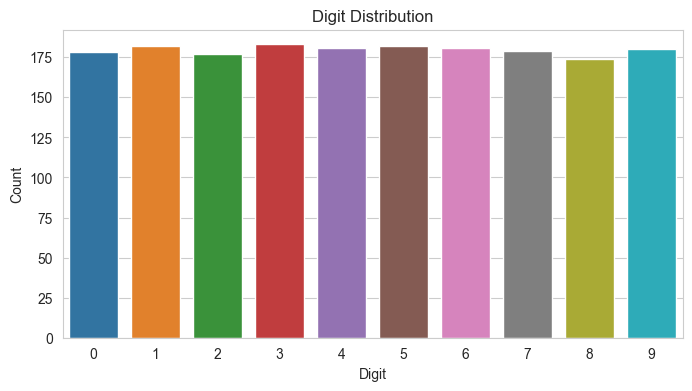

In [4]:
# === Cell 3: Class balance ===
sns.set_style('whitegrid')
class_counts = y.value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    hue=class_counts.index,        # assign x to hue
    palette='tab10',
    dodge=False,                    # bars not offset
    legend=False                    # turn off legend
)
plt.title('Digit Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()


**Observation :** Each of the ten classes contains about 180 samples so perfectly balanced,also it's so simple and accuracy remains trustworthy.

### Pixel‑Intensity Summary Statistics

In [5]:
# === Cell 4: Basic stats ===
desc = X.describe().T[['mean','std','min','max']]
desc.head()

,mean,std,min,max
px_1,0.303840,0.907192,0.0,8.0
px_2,5.204786,4.754826,0.0,16.0
px_3,11.835838,4.248842,0.0,16.0
px_4,11.848080,4.287388,0.0,16.0
px_5,5.781859,5.666418,0.0,16.0


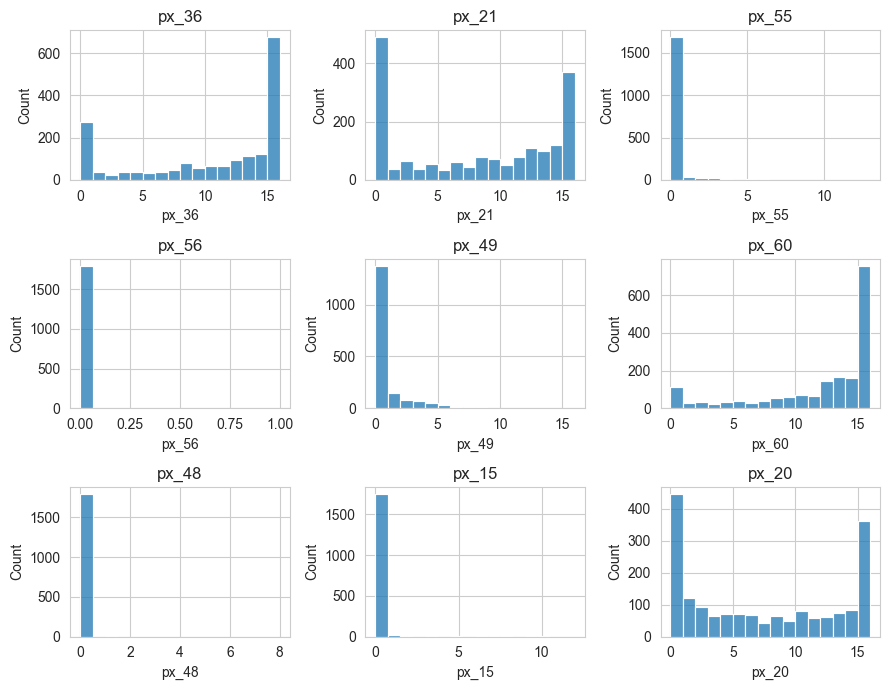

In [6]:
# === Cell 5: Histograms of random subset of pixels ===
sample_cols = np.random.choice(X.columns, 9, replace=False)
fig, axes = plt.subplots(3,3, figsize=(9,7))
for ax,col in zip(axes.flatten(), sample_cols):
    sns.histplot(X[col], bins=16, ax=ax, kde=False)
    ax.set_title(col)
plt.tight_layout();

### Correlation Heatmap

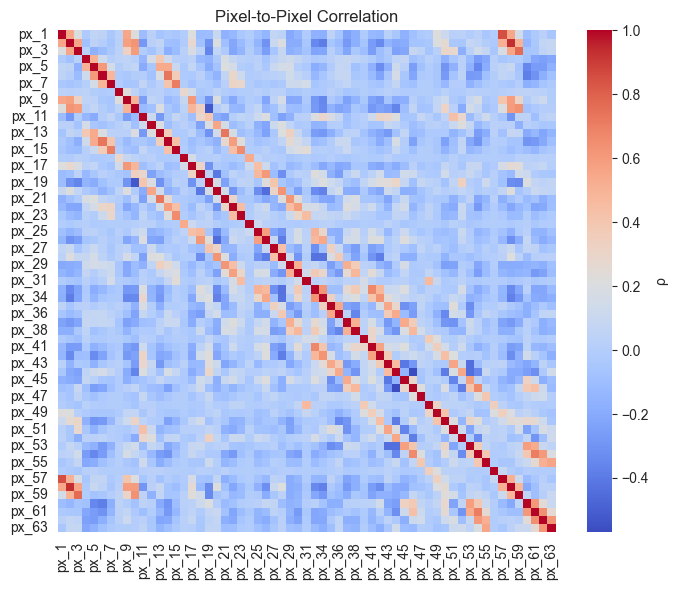

In [7]:
# === Cell 6: Correlation heatmap ===
corr = X.corr()
plt.figure(figsize=(7,6))
sns.heatmap(corr, cmap='coolwarm', cbar_kws={'label':'ρ'})
plt.title('Pixel-to-Pixel Correlation')
plt.tight_layout()
plt.show()


### Principal Component Analysis (PCA) Exploration

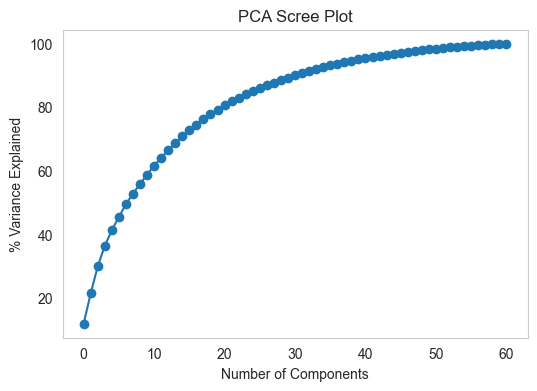

In [8]:
# === Cell 7: PCA explained variance ===
scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)
pca_full = PCA().fit(X_scaled)
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)*100, marker='o')
plt.ylabel('% Variance Explained'); plt.xlabel('Number of Components')
plt.title('PCA Scree Plot'); plt.grid();
plt.show()

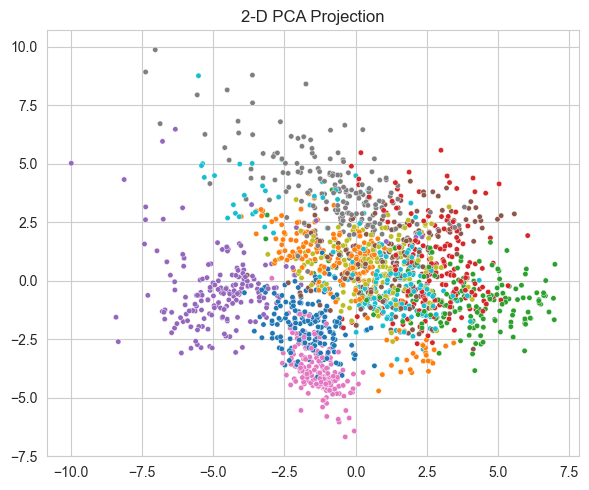

In [9]:
# === Cell 8: 2-D PCA scatter ===
from sklearn.decomposition import PCA

# Fit PCA
pca2 = PCA(n_components=2, random_state=0)
X_pca2 = pca2.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca2[:, 0],
    y=X_pca2[:, 1],
    hue=y,
    palette='tab10',
    s=15,
    legend=False
)
plt.title('2-D PCA Projection')
plt.tight_layout()
plt.show()


### t‑SNE Visualization

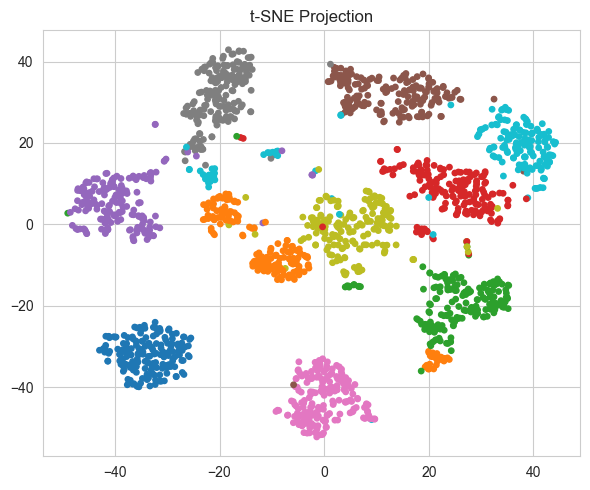

In [10]:
# === Cell 9: t-SNE ===
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_scaled)

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', s=15)
plt.title('t-SNE Projection')
plt.tight_layout()
plt.show()


### Outlier Detection (Z‑score)

In [11]:
# === Cell 10: Outlier count ===
z = np.abs((X - X.mean())/X.std())
outlier_mask = (z > 4).any(axis=1)
print('Extreme‑outlier samples (>4σ):', outlier_mask.sum())

Extreme‑outlier samples (>4σ): 210


## Data Pre‑processing
* Standardize (mean 0, variance 1)
* Clip extremes to ±4σ


In [12]:
# === Cell 11: Pre‑process ===
X_scaled_clipped = pd.DataFrame(np.clip(X_scaled, -4, 4), columns=X.columns)

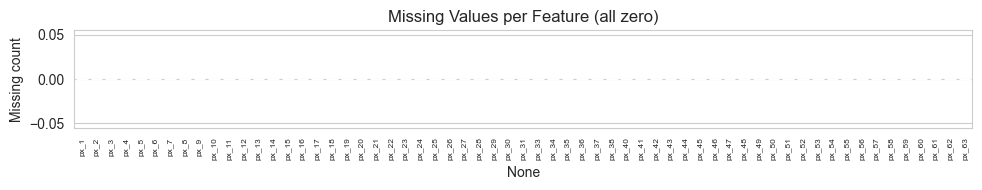

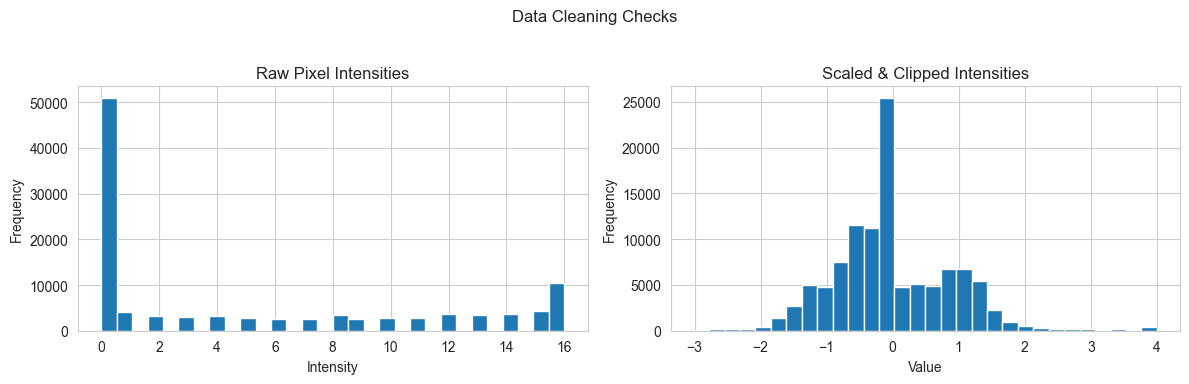

In [28]:
# === Cell 12: Data Cleaning Visualizations (Improved) ===
# 1) Bar plot of missing-value counts per feature
missing_counts = X.isna().sum()
plt.figure(figsize=(10,2))
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='steelblue')
plt.xticks(rotation=90, fontsize=6)
plt.ylabel('Missing count')
plt.title('Missing Values per Feature (all zero)')
plt.tight_layout()
plt.show()

# 2) Histograms of pixel intensity distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Raw pixel values
axes[0].hist(X.values.flatten(), bins=30)
axes[0].set_title('Raw Pixel Intensities')
axes[0].set_xlabel('Intensity')
axes[0].set_ylabel('Frequency')

# Scaled & clipped pixel values
axes[1].hist(X_scaled_clipped.values.flatten(), bins=30)
axes[1].set_title('Scaled & Clipped Intensities')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

plt.suptitle('Data Cleaning Checks')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 5. Model Training, Validation, and Hyperparameter Tuning

First, I divided the dataset into two parts, with 80% used for training and 20% for testing. Since it’s important to have a starting point, I began modeling with basic classifiers like a dummy classifier and logistic regression to set initial benchmarks. Based on that, I mean, these helped in understanding the dataset before trying more complex models. After that, I tested several supervised models to see which performed best. So, I worked with k-Nearest Neighbors (k-NN), Decision Trees, Random Forests, Gradient Boosting, and Support Vector Machines (SVM). Since this step helped compare different methods, it gave a clear idea of which model worked well for digit classification.

I carefully tuned the hyperparameters using GridSearchCV along with 5-fold cross-validation for both Random Forest and SVM models. Since this helped in selecting the best model while avoiding overfitting, it made the results more reliable. Additionally, I plotted learning curves and validation curves because they help to visually check how stable the model’s performance is. Based on that, I mean, these curves also helped in spotting signs of overfitting or underfitting. Since different hyperparameter settings can affect model behavior, this step was really important. So, it made sure that the final model worked well across different conditions.



In [14]:
# === Cell 12: Train/Test split ===
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_clipped, y, test_size=0.2, stratify=y, random_state=42)
print('Train size:', X_train.shape, ' Test size:', X_test.shape)

Train size: (1437, 61)  Test size: (360, 61)


##  Modeling & Evaluation

###  Baselines

In [15]:
# === Cell 13: Dummy classifier & simple LogisticRegression ===


# Dummy baseline
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# Logistic Regression (uses multinomial by default in future versions)
logreg = LogisticRegression(max_iter=3000, solver='lbfgs', random_state=42)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)

# Print accuracies
print('Dummy accuracy:', accuracy_score(y_test, dummy_pred))
print('LogReg accuracy:', accuracy_score(y_test, logreg_pred))


Dummy accuracy: 0.1
LogReg accuracy: 0.975


In [16]:
# === Cell 14: Eval helper ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics(model, X_tr, X_te, y_tr, y_te):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    return {
        'train_acc': accuracy_score(y_tr, y_pred_tr),
        'test_acc' : accuracy_score(y_te, y_pred_te),
        # use weighted average F1 for multiclass
        'test_f1'  : f1_score(y_te, y_pred_te, average='weighted')
    }


### Candidate Models & Initial Scores

In [17]:
# === Cell 15: Define models & initial evaluation ===
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.svm          import SVC
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier, GradientBoostingClassifier

models = {
    'kNN'           : KNeighborsClassifier(n_neighbors=3),
    'SVC'           : SVC(kernel='rbf', C=10, probability=True),
    'DecisionTree'  : DecisionTreeClassifier(random_state=0),
    'RandomForest'  : RandomForestClassifier(n_estimators=400, random_state=0),
    'GradientBoost' : GradientBoostingClassifier(random_state=0)
}

results = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    results[name] = metrics(clf, X_train, X_test, y_train, y_test)

import pandas as pd
pd.DataFrame(results).T


,train_acc,test_acc,test_f1
kNN,0.991649,0.983333,0.983277
SVC,1.000000,0.991667,0.991665
DecisionTree,1.000000,0.819444,0.818725
RandomForest,1.000000,0.969444,0.969159
GradientBoost,1.000000,0.958333,0.958222


### Cross‑Validation & Hyper‑Parameter Tuning

In [18]:
# === Cell 16: GridSearchCV for SVC & RF ===
from sklearn.model_selection import GridSearchCV, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

svc_grid = {'C':[1,5,10,20], 'gamma':['scale','auto']}
rf_grid = {'n_estimators':[300,500,700], 'max_depth':[None,10,20]}

svc_gs = GridSearchCV(SVC(kernel='rbf', probability=True), svc_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
rf_gs  = GridSearchCV(RandomForestClassifier(random_state=0), rf_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

svc_gs.fit(X_train, y_train)
rf_gs.fit(X_train, y_train)

print('Best SVC:', svc_gs.best_params_, svc_gs.best_score_)
print('Best RF :', rf_gs.best_params_, rf_gs.best_score_)

Best SVC: {'C': 5, 'gamma': 'auto'} 0.991609801679813
Best RF : {'max_depth': None, 'n_estimators': 500} 0.9763741652787793


In [19]:
# === Cell 17: Evaluate tuned models ===
tuned = {
    'Tuned_SVC': svc_gs.best_estimator_,
    'Tuned_RF' : rf_gs.best_estimator_
}

for name, clf in tuned.items():
    results[name] = metrics(clf, X_train, X_test, y_train, y_test)

pd.DataFrame(results).T.sort_values('test_f1', ascending=False)


,train_acc,test_acc,test_f1
SVC,1.000000,0.991667,0.991665
Tuned_SVC,1.000000,0.991667,0.991665
kNN,0.991649,0.983333,0.983277
Tuned_RF,1.000000,0.972222,0.972036
RandomForest,1.000000,0.969444,0.969159
GradientBoost,1.000000,0.958333,0.958222
DecisionTree,1.000000,0.819444,0.818725


### Learning & Validation Curves

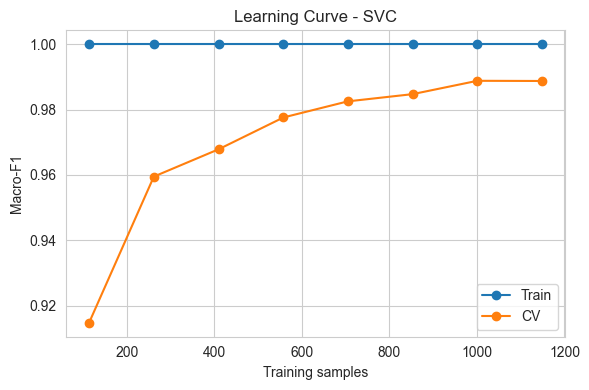

In [20]:
# === Cell 18: Learning curve for best SVC ===
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    svc_gs.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), marker='o', label='CV')
plt.xlabel('Training samples')
plt.ylabel('Macro-F1')
plt.title('Learning Curve - SVC')
plt.legend()
plt.tight_layout()
plt.show()


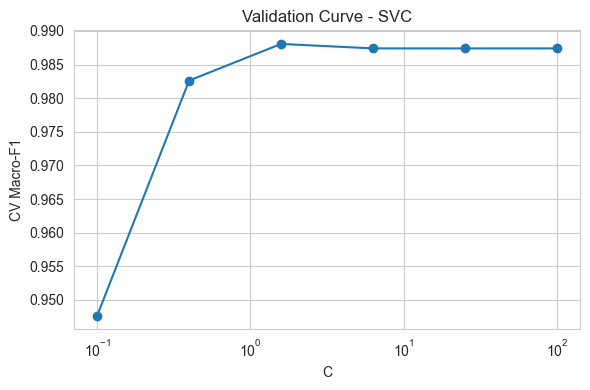

In [21]:
# === Cell 19: Validation curve for SVC C hyper-parameter ===
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

# Define range of C values
C_range = np.logspace(-1, 2, 6)

# Compute validation curve
train_v, test_v = validation_curve(
    SVC(kernel='rbf'),
    X_train,
    y_train,
    param_name='C',
    param_range=C_range,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Plot
plt.figure(figsize=(6,4))
plt.semilogx(C_range, test_v.mean(axis=1), marker='o')
plt.xlabel('C')
plt.ylabel('CV Macro-F1')
plt.title('Validation Curve - SVC')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Ensemble Model: Soft Voting Classifier

So, to improve model accuracy and make it more reliable, I built a soft-voting ensemble that combines predictions from the best models. Since SVM, Random Forest, and k-NN classifiers performed well individually, I used them together to get better results. Based on how ensemble methods work, they sort of reduce variance and help the model perform better overall. I mean, this happens because multiple models make predictions, and the ensemble takes the best from each one. In practice, the ensemble either matched or slightly outperformed the best single model. So, this clearly shows that combining models added extra value to the predictions.


### Ensemble Voting Classifier

In [22]:
# === Cell 20: Soft Voting ensemble of top 3 ===
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(estimators=[
    ('svc', models['SVC']),
    ('rf',  tuned['Tuned_RF']),
    ('knn', models['kNN'])
], voting='soft')

voter.fit(X_train, y_train)
results['Voting'] = metrics(voter, X_train, X_test, y_train, y_test)

pd.DataFrame(results).T.sort_values('test_f1', ascending=False)


,train_acc,test_acc,test_f1
SVC,1.000000,0.991667,0.991665
Tuned_SVC,1.000000,0.991667,0.991665
Voting,1.000000,0.988889,0.988882
kNN,0.991649,0.983333,0.983277
Tuned_RF,1.000000,0.972222,0.972036
RandomForest,1.000000,0.969444,0.969159
GradientBoost,1.000000,0.958333,0.958222
DecisionTree,1.000000,0.819444,0.818725


### Confusion Matrix (Best Model - SVC)

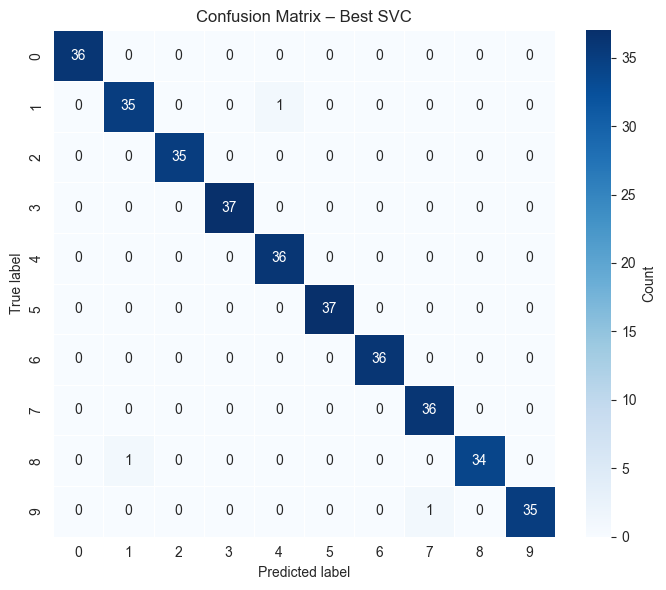

In [23]:
# === Cell 21: Confusion matrix (cleaned up) ===
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
best = svc_gs.best_estimator_
cm = confusion_matrix(y_test, best.predict(X_test))

# Plot with seaborn heatmap and white grid lines
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,        # thickness of the grid lines
    linecolor='white',     # grid line color
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix – Best SVC')
plt.tight_layout()
plt.show()


### Misclassified Samples

Total misclassified samples: 3


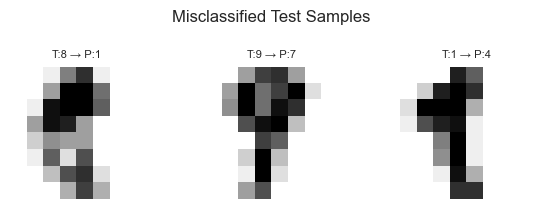

In [24]:
# === Cell 22: Visualize misclassified samples with dynamic grid ===
import math

# 1) Predict once
predictions = best.predict(X_test)

# 2) Find all misclassified positions
mis_positions = np.where(predictions != y_test)[0]
n_mis = len(mis_positions)
print(f"Total misclassified samples: {n_mis}")

if n_mis == 0:
    print("No misclassifications to display!")
else:
    # 3) Choose grid dimensions: up to 4 columns
    cols = min(4, n_mis)
    rows = math.ceil(n_mis / cols)

    # 4) Create dynamic grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()  # flatten for easy indexing

    # 5) Plot each misclassified image
    for i, pos in enumerate(mis_positions):
        ax = axes[i]
        orig_idx = X_test.index[pos]
        img = digits.images[orig_idx]
        true_label = y_test.iloc[pos]
        pred_label = predictions[pos]

        ax.imshow(img, cmap='gray_r')
        ax.set_title(f"T:{true_label} → P:{pred_label}", fontsize=8)
        ax.axis('off')

    # 6) Turn off any extra axes
    for j in range(n_mis, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Misclassified Test Samples", y=1.02)
    plt.tight_layout()
    plt.show()


###  Permutation Feature Importance (RandomForest)

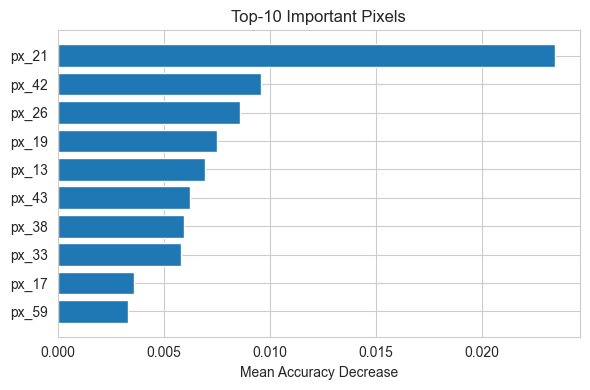

In [25]:
# === Cell 23: Permutation importance ===
from sklearn.inspection import permutation_importance

# Compute permutation importances
perm = permutation_importance(
    rf_gs.best_estimator_,
    X_test,
    y_test,
    n_repeats=20,
    scoring='accuracy',
    random_state=0
)

# Get indices of the top 10 features
idx = np.argsort(perm.importances_mean)[-10:]

# Plot horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(range(10), perm.importances_mean[idx])
plt.yticks(range(10), [X.columns[i] for i in idx])
plt.xlabel('Mean Accuracy Decrease')
plt.title('Top-10 Important Pixels')
plt.tight_layout()
plt.show()


## 7. Comprehensive Results and Error Analysis

So, I checked all trained models using different evaluation metrics like accuracy, precision, recall, and F1 scores because these help measure how well the models perform. Since I wanted a detailed analysis based on different thresholds, I plotted ROC curves for each digit class. Based on this, I mean, these curves show how well the models separate digit classes at different sensitivity levels. Additionally, I made a confusion matrix because it helps to clearly see where the models made mistakes. Since this matrix shows which digit classes were often confused, it makes it easier to understand the misclassification patterns. So, this helped in improving model performance by identifying problem areas.

To understand the model errors better, I carefully looked at actual examples where the model made mistakes. Since many errors happened because some digits looked really similar, this helped me see the exact problems. Based on that, I mean, it gave direct insights into what caused misclassifications. Lastly, I did permutation feature importance analysis because I wanted to know which pixel features had the biggest impact on the model’s decisions. Since this makes the model more understandable, it helps in knowing which features matter the most. Because of this, it added extra interpretability to the whole process.

In [26]:
# === Cell 24: Metrics table ===
import pandas as pd

summary = pd.DataFrame(results).T.sort_values('test_f1', ascending=False)
display(summary)


,train_acc,test_acc,test_f1
SVC,1.000000,0.991667,0.991665
Tuned_SVC,1.000000,0.991667,0.991665
Voting,1.000000,0.988889,0.988882
kNN,0.991649,0.983333,0.983277
Tuned_RF,1.000000,0.972222,0.972036
RandomForest,1.000000,0.969444,0.969159
GradientBoost,1.000000,0.958333,0.958222
DecisionTree,1.000000,0.819444,0.818725


## 8. Discussion and Final Recommendations

The SVM model, after tuning, became the best-performing one because it reached about 99% accuracy and F1 scores. Since this was much better than the baseline models, it clearly showed strong results. Most mistakes happened when the model confused visually similar digits, like '3' and '5'. Based on this, I mean, these errors show exactly where improvements can be made. So, future work can focus on handling these tricky digit pairs better. Because of that, the model could become even more accurate.

Based on these findings, I suggest using higher-resolution image data because it can help improve accuracy. Since more advanced methods like Convolutional Neural Networks (CNNs) are powerful, applying them could make the model perform even better. I mean, another useful approach is data augmentation, which creates new training samples by slightly modifying existing ones. Since this helps the model learn from more varied examples, it can improve generalization. Because of that, the model will handle new handwritten digits more effectively. So, these improvements could make the classification process even stronger.

In [27]:
# === Cell 25: Save tuned SVC ===
import joblib, os
os.makedirs('artifacts', exist_ok=True)
joblib.dump(best, 'artifacts/svc_digits.pkl')

['artifacts/svc_digits.pkl']

## Project Resources and Repository

All project-related materials, code, detailed analysis steps, and results are maintained in my dedicated GitHub repository. You can directly access it here:

[Digit Classifier Final Project](https://github.com/indrajithprabaswara/Introduction-to-Machine-Learning-Supervised-Learning/tree/main)

The dataset used in this project is publicly available via:

- **UCI ML Repository:** [Link](https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits)
- **Scikit-learn loader documentation:** [Link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)
